<a href="https://colab.research.google.com/github/tayfununal/2-Hidden-Layer-Neural-Networks/blob/master/Tik_3/to_Uniform/Digits/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import random
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

%matplotlib inline
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

In [8]:
class NoiseTransform:
    """Add some noise."""

    def __init__(self, dim=64):
        self.normal_dist = torch.distributions.normal.Normal(loc=torch.zeros((dim,)), scale=0.001*torch.ones((dim,)))

    def __call__(self, x):
      return x + self.normal_dist.sample((1,)).reshape((1,8,8))

class Digits(Dataset):
  def __init__(self, train=True, transforms=None):
    super(Digits, self).__init__()

    self.transforms = transforms
    self.train = train
    digits = load_digits()

    X , X_test, y, y_test = train_test_split(digits.data, digits.target,
                                                    stratify=digits.target,
                                                    test_size=0.20,
                                                   random_state=42)
    X = X.reshape((-1,1,8,8))                                                     # N,Chanel, Width, Height
    X = (X - X.min()) / (X.max()-X.min())
    X = torch.from_numpy(X).type(torch.float32)
    y = torch.from_numpy(y).type(torch.float32)

    X_test = X_test.reshape((-1,1,8,8))
    X_test = (X_test - X_test.min()) / (X_test.max() - X_test.min())
    X_test = torch.from_numpy(X_test).type(torch.float32)
    y_test = torch.from_numpy(y_test).type(torch.float32)

    if self.train:
      self.dataset = {'data':X, 'target':y}
    else:
      self.dataset = {'data':X_test, 'target':y_test}

  def __len__(self):
    return len(self.dataset['data'])

  def __getitem__(self, idx):

    y = self.dataset['target'][idx]

    if self.transforms:
      x = self.dataset['data'][idx]
      x_ = self.transforms(x)
      return x, x_, y

    else:
      x = self.dataset['data'][idx]
      return x, y

In [9]:
class To_Uniform(torch.nn.Module):

    def __init__(self):
        super(To_Uniform, self).__init__()

      # ********************** Encoder **************************
        self.en_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=2, stride=1, padding=0), # [(width - kernal + 2 * padding) / slide] + 1
            nn.ReLU(),
            nn.BatchNorm2d(16)
        )
        self.en_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=2, stride=1, padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(16)
        )
        self.en_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=2, stride=1, padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(16)
        )
        self.en_linear1 = nn.Sequential(
            nn.Linear(400, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024)
        )
        self.en_linear2 = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024)
        )
        self.en_linear3 = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024)
        )
        self.en_linear4 = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024)
        )
        self.en_linear5 = nn.Sequential(
            nn.Linear(1024, 3),
            nn.Sigmoid(),
            nn.BatchNorm1d(3)
        )
      # ********************** Encoder **************************
      # ********************** Decoder **************************
        self.de_linear1 = nn.Sequential(
            nn.Linear(3, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024)
        )
        self.de_linear2 = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024)
        )
        self.de_linear3 = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024)
        )
        self.de_linear4 = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024)
        )
        self.de_linear5 = nn.Sequential(
            nn.Linear(1024, 64),
            nn.Sigmoid(),
            nn.BatchNorm1d(64)
        )
      # ********************** Decoder **************************
    def encoder(self, x):
        x = self.en_conv1(x)
        x = self.en_conv2(x)
        x = self.en_conv3(x)
        x = torch.flatten(x, start_dim=1)
        x = self.en_linear1(x)
        x = self.en_linear2(x)
        x = self.en_linear3(x)
        x = self.en_linear4(x)
        x = self.en_linear5(x)
        return x

    def decoder(self, x):
        x = self.de_linear1(x)
        x = self.de_linear2(x)
        x = self.de_linear3(x)
        x = self.de_linear4(x)
        x = self.de_linear5(x)
        return x

    def forward(self, x):
        en_x = self.encoder(x)
        de_x = self.decoder(en_x)
        return en_x, de_x

    def criterion(self, en_x_pred, en_x_target, de_x_pred, de_x_target):
      return -nn.MSELoss()(en_x_pred, en_x_target) + nn.MSELoss()(de_x_pred, de_x_target)

In [10]:
model = To_Uniform()
digits = Digits(transforms=NoiseTransform())
train_loader = DataLoader(digits, batch_size=256, shuffle=True)

In [11]:
epochs = 100
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)

COST = []

for epoch in range(epochs):
    total_loss = []

    for x, x_, _ in train_loader:

        with torch.no_grad():
          en_x_, de_x_ = model(x_)
        en_x, de_x = model(x)

        loss = model.criterion(en_x_pred=en_x, en_x_target=en_x_, de_x_pred=de_x, de_x_target=x.reshape(-1,64))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss.append(loss.item())

    COST.append(np.mean(total_loss))

    if epoch==0:
        print("Epoch : ", epoch+1, "  -----------> Loss : ", np.mean(total_loss))
    elif (epoch+1)%10 == 0:
        print("Epoch : ", epoch+1, "  -----------> Loss : ", np.mean(total_loss))

Epoch :  1   -----------> Loss :  1.1212021907170613
Epoch :  10   -----------> Loss :  0.2100114276011785
Epoch :  20   -----------> Loss :  0.041194391126434006
Epoch :  30   -----------> Loss :  0.02930447676529487
Epoch :  40   -----------> Loss :  0.026721753800908726
Epoch :  50   -----------> Loss :  0.026278166100382805
Epoch :  60   -----------> Loss :  0.02908556753148635
Epoch :  70   -----------> Loss :  0.02496323548257351
Epoch :  80   -----------> Loss :  0.023963203964134056
Epoch :  90   -----------> Loss :  0.022841876993576687
Epoch :  100   -----------> Loss :  0.024439184616009395


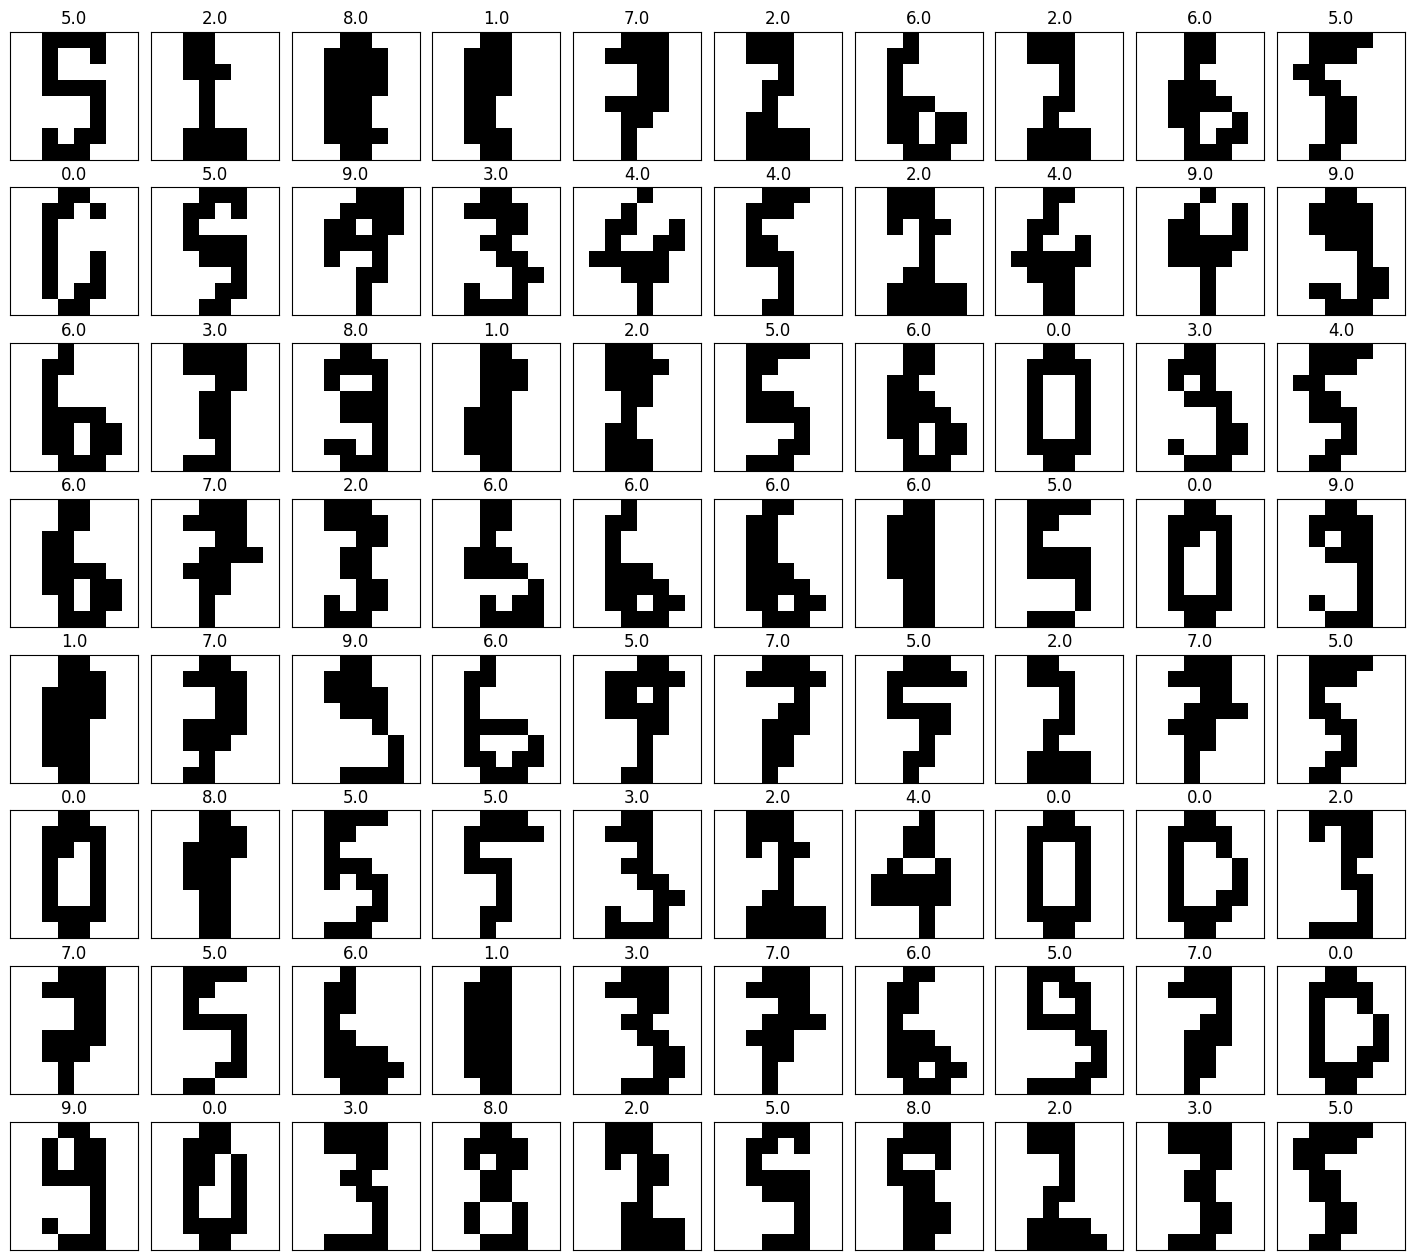

In [12]:
test_data = Digits(train=False)
X_test = test_data.dataset['data']
y_test = test_data.dataset['target']

encode_sonuc, sonuc = model(X_test[:])

sonuc[sonuc>=0.5] = 1
sonuc[sonuc<0.5]  = 0

fig, axs = plt.subplots(8, 10, sharex=True, sharey=True, figsize=(18, 16), subplot_kw={'xticks':[], 'yticks':[]}, gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i in range(0,10):
    axs[0, i].imshow((sonuc[i]).detach().numpy().clip(0,1).reshape((8,8)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[0, i].set_title(f'{y_test[i]}')
    axs[1, i].imshow((sonuc[10+i]).detach().numpy().clip(0,1).reshape((8,8)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[1, i].set_title(f'{y_test[10+i]}')
    axs[2, i].imshow((sonuc[20+i]).detach().numpy().clip(0,1).reshape((8,8)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[2, i].set_title(f'{y_test[20+i]}')
    axs[3, i].imshow((sonuc[30+i]).detach().numpy().clip(0,1).reshape((8,8)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[3, i].set_title(f'{y_test[30+i]}')
    axs[4, i].imshow((sonuc[40+i]).detach().numpy().clip(0,1).reshape((8,8)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[4, i].set_title(f'{y_test[40+i]}')
    axs[5, i].imshow((sonuc[50+i]).detach().numpy().clip(0,1).reshape((8,8)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[5, i].set_title(f'{y_test[50+i]}')
    axs[6, i].imshow((sonuc[60+i]).detach().numpy().clip(0,1).reshape((8,8)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[6, i].set_title(f'{y_test[60+i]}')
    axs[7, i].imshow((sonuc[70+i]).detach().numpy().clip(0,1).reshape((8,8)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[7, i].set_title(f'{y_test[70+i]}')
fig.show()


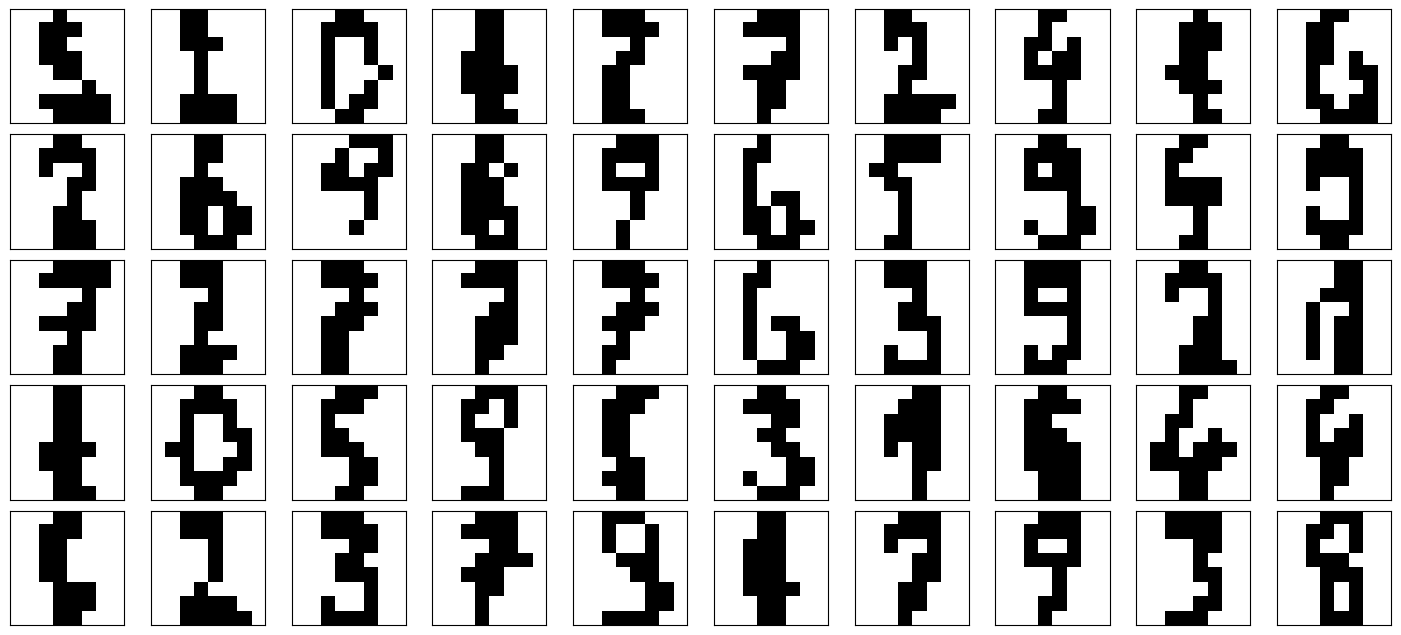

In [13]:
uniform_dist = torch.distributions.uniform.Uniform(low=torch.zeros((3,)), high=1)

de_sonuc = model.decoder(uniform_dist.sample((50,)))

de_sonuc[de_sonuc>=0.5] = 1
de_sonuc[de_sonuc<0.5] = 0

fig, axs = plt.subplots(5, 10, sharex=True, sharey=True, figsize=(18, 8), subplot_kw={'xticks':[], 'yticks':[]}, gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i in range(0,10):
    axs[0, i].imshow((de_sonuc[i]).detach().numpy().clip(0,1).reshape((8,8)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[1, i].imshow((de_sonuc[10+i]).detach().numpy().clip(0,1).reshape((8,8)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[2, i].imshow((de_sonuc[20+i]).detach().numpy().clip(0,1).reshape((8,8)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[3, i].imshow((de_sonuc[30+i]).detach().numpy().clip(0,1).reshape((8,8)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[4, i].imshow((de_sonuc[40+i]).detach().numpy().clip(0,1).reshape((8,8)), cmap='binary', interpolation='nearest', clim=(0, 1))

fig.show()

In [14]:
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

df = pd.DataFrame(encode_sonuc.detach().numpy())
fig = px.scatter_3d(df,0,1,2,color=y_test)

fig.show()